
# TO COMPLETE

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\nizon\AppData\Local\Temp\ipykernel_12932\687462750.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
file_path = '../airflow/data/production/flights.csv'
df = pd.read_csv(file_path)
df.head()

,id,scheduled_time,departure_icao,arrival_icao,delay_in_minutes,flight_status,airline,flight_number,departure_wind,departure_visibility,departure_sky_condition,departure_temperature,departure_altimeter,destination_wind,destination_visibility,destination_sky_condition,destination_temperature,destination_altimeter
0,75,2025-01-05T12:10:00.000,kfll,kmco,34,active,southwest airlines,2984,30003KT,10SM,SCT040,13/11,3022.0,36005KT,10SM,FEW250,07/02,3025.0
1,77,2025-01-04T23:45:00.000,kfll,kmco,42,active,jetblue airways,8370,02010G20KT,10SM,FEW250,22/11,3019.0,02006KT,10SM,FEW250,13/M02,3027.0
2,79,2025-01-05T13:00:00.000,kfll,kmco,0,active,southwest airlines,8503,30003KT,10SM,SCT040,13/11,3022.0,32004KT,10SM,FEW250,08/03,3027.0
3,81,2025-01-05T21:12:00.000,kfll,kmco,28,active,spirit airlines,676,30003KT,10SM,SCT040,13/11,3022.0,14008KT,10SM,BKN250,21/04,3015.0
4,83,2025-01-06T07:30:00.000,kfll,kmco,19,active,azul,6967,15009KT,10SM,FEW037,21/13,3006.0,21004KT,10SM,CLR,13/11,3009.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         151 non-null    int64  
 1   scheduled_time             151 non-null    object 
 2   departure_icao             151 non-null    object 
 3   arrival_icao               151 non-null    object 
 4   delay_in_minutes           151 non-null    int64  
 5   flight_status              151 non-null    object 
 6   airline                    151 non-null    object 
 7   flight_number              151 non-null    int64  
 8   departure_wind             151 non-null    object 
 9   departure_visibility       151 non-null    object 
 10  departure_sky_condition    151 non-null    object 
 11  departure_temperature      151 non-null    object 
 12  departure_altimeter        150 non-null    float64
 13  destination_wind           151 non-null    object 

C:\Users\nizon\AppData\Local\Temp\ipykernel_12932\558016399.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=airline_delays.index, y=airline_delays.values, palette='viridis')


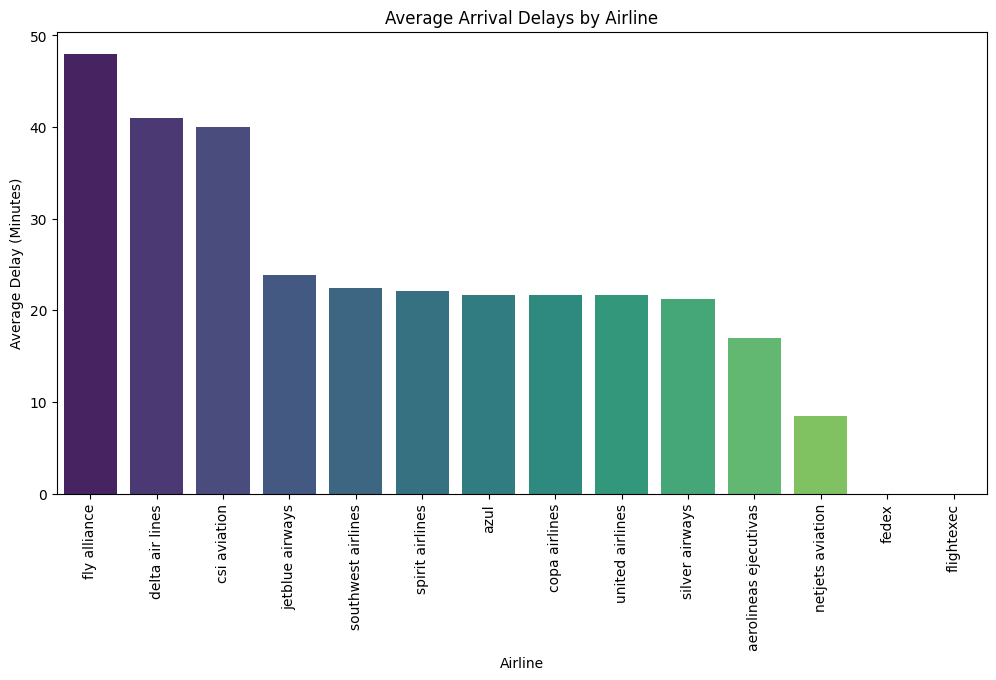

In [7]:
# Group by airline and calculate mean delays
airline_delays = df.groupby('airline')['delay_in_minutes'].mean().sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x=airline_delays.index, y=airline_delays.values, palette='viridis')
plt.title('Average Arrival Delays by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=90)
plt.show()

In [19]:
import re

# Function to determine if the wind is strong (e.g., > 30 knots)
def is_strong_wind(wind):
    match = re.search(r'(\d{2})', wind)  # Find the first two digits (wind speed in knots)
    if match:
        wind_speed = int(match.group(1))
        return wind_speed > 30
    return False

# Function to check visibility (e.g., < 3 statute miles)
def is_low_visibility(visibility):
    if 'SM' in visibility:
        visibility_value = float(visibility.replace('SM', ''))
        return visibility_value < 3
    return False

# Function to check if sky condition is bad (e.g., BKN or OVC)
def is_bad_sky_condition(sky_condition):
    if 'BKN' in sky_condition or 'OVC' in sky_condition:
        return True
    return False

# Function to check if the temperature is extreme (e.g., below -5°C or above 40°C)
def is_extreme_temperature(temperature):
    match = re.match(r'(\d+)', temperature.split('/')[0])  # Extract temperature from format like "07/02"
    if match:
        temp = int(match.group(1))
        return temp < -5 or temp > 40
    return False

# Now we apply these functions to create a 'BadWeatherDeparture' column
def determine_bad_weather_departure(weather_row):
    wind, visibility, sky_condition, temperature = weather_row
    if (is_strong_wind(wind) or 
        is_low_visibility(visibility) or 
        is_bad_sky_condition(sky_condition) or 
        is_extreme_temperature(temperature)):
        return 1  # Bad weather
    return 0  # Good weather


C:\Users\nizon\AppData\Local\Temp\ipykernel_12932\739085201.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='BadWeatherDeparture', y='delay_in_minutes', data=df, palette='coolwarm')


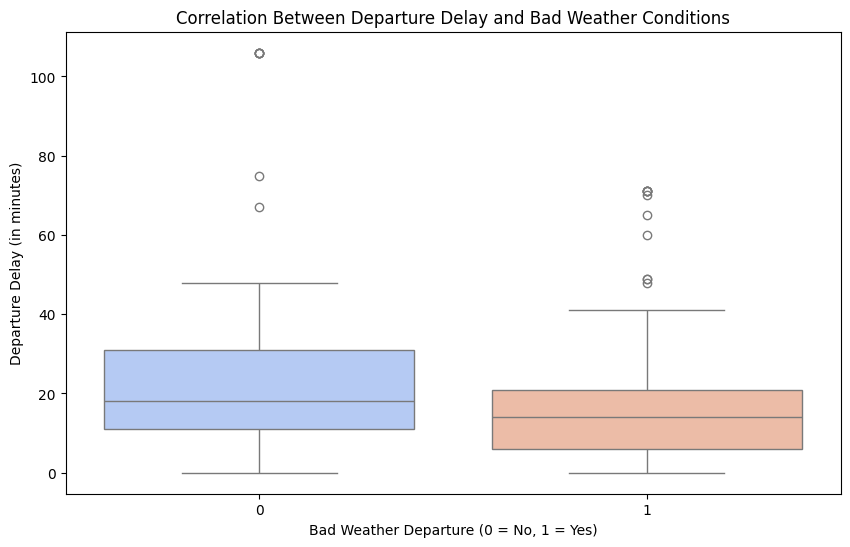

In [ ]:
df_departure = df

# Apply the function to the 'WeatherDeparture' column
df_departure['BadWeatherDeparture'] = df_departure[['departure_wind', 'departure_visibility', 'departure_sky_condition', 'departure_temperature']].apply(determine_bad_weather_departure, axis=1)

df_departure = df_departure.dropna(subset=['delay_in_minutes', 'BadWeatherDeparture'])

# Create a scatter plot to show the correlation
plt.figure(figsize=(10, 6))
sns.boxplot(x='BadWeatherDeparture', y='delay_in_minutes', data=df_departure, palette='coolwarm')

# Set plot title and labels
plt.title('Correlation Between Departure Delay and Bad Weather Conditions')
plt.xlabel('Bad Weather Departure (0 = No, 1 = Yes)')
plt.ylabel('Departure Delay (in minutes)')

# Show plot
plt.show()

C:\Users\nizon\AppData\Local\Temp\ipykernel_12932\3011454321.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='BadWeatherDestination', y='delay_in_minutes', data=df_destination, palette='coolwarm')


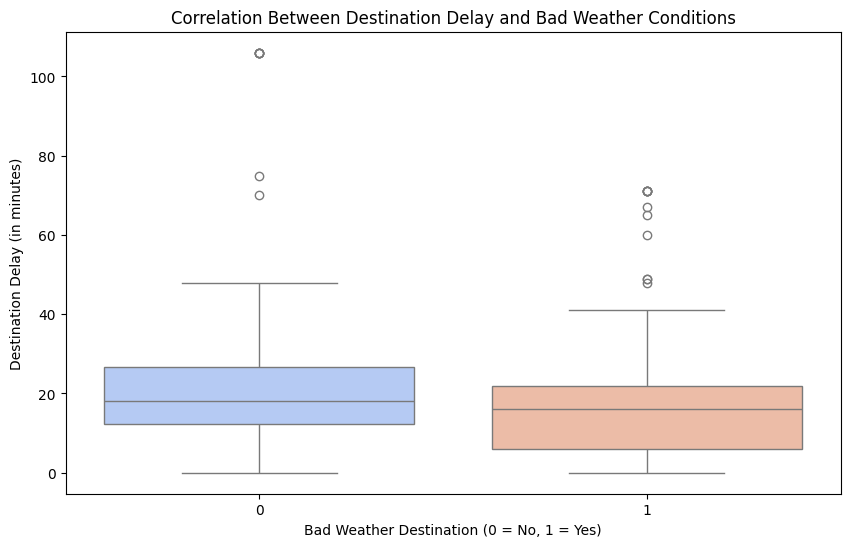

In [24]:
df_destination = df

# Apply the function to the 'WeatherDeparture' column
df_destination['BadWeatherDestination'] = df_destination[['destination_wind', 'destination_visibility', 'departure_sky_condition', 'departure_temperature']].apply(determine_bad_weather_departure, axis=1)

df_destination = df_destination.dropna(subset=['delay_in_minutes', 'BadWeatherDestination'])

# Create a scatter plot to show the correlation
plt.figure(figsize=(10, 6))
sns.boxplot(x='BadWeatherDestination', y='delay_in_minutes', data=df_destination, palette='coolwarm')

# Set plot title and labels
plt.title('Correlation Between Destination Delay and Bad Weather Conditions')
plt.xlabel('Bad Weather Destination (0 = No, 1 = Yes)')
plt.ylabel('Destination Delay (in minutes)')

# Show plot
plt.show()